## 读取数据

In [1]:
import numpy as np
import pandas as pd
import torch
import os
from sklearn.metrics import mean_absolute_error
def createXY(dataset,npast,n_future,column_target):
    dataX,dataY=[],[]
    for i in range(npast,dataset.shape[0]-n_future+1):
        dataX.append(dataset.iloc[i-npast:i].values)
        dataY.append(dataset.iloc[i:i+n_future][column_target].values)
    return np.array(dataX),np.array(dataY)

def processFiles(need_columns,target_column,all_df,n_past=1,n_future=1):
    all_x,all_y=np.array([]),np.array([])
    for df in all_df:
        df=df[need_columns]
        x,y=createXY(df,n_past,n_future,target_column)
        all_x=np.vstack([all_x,x]) if all_x.size else x
        all_y=np.vstack([all_y,y]) if all_y.size else y
    return all_x,all_y

def processSummary(summary_columns,summary,folder_path):
    all_df=[]
    for f in os.listdir(folder_path):
        if f.endswith('.xlsx') or f.endswith('.xls'):
            df=pd.read_excel(folder_path+f)
            df['Patient Number']=f.split('.')[0]
            df=pd.merge(df,summary[summary_columns],on='Patient Number')
            all_df.append(df)
    return all_df

need_columns=['Date','CGM (mg / dl)','CBG (mg / dl)']
target_column='CGM (mg / dl)'
summary_columns=['Patient Number',
                 'Age (years)',
                 'BMI (kg/m2)',
                 'Type of Diabetes']
need_columns.extend(summary_columns)

summary1=pd.read_excel('./data/Shanghai_T1DM_Summary.xlsx')
summary2=pd.read_excel('./data/Shanghai_T2DM_Summary.xlsx')

summary1['Type of Diabetes']=summary1['Type of Diabetes'].apply(lambda x: 1 if x=='T1DM' else 2)
summary2['Type of Diabetes']=summary2['Type of Diabetes'].apply(lambda x: 1 if x=='T1DM' else 2)

summary1['Alcohol Drinking History (drinker/non-drinker)']=summary1['Alcohol Drinking History (drinker/non-drinker)'].apply(lambda x: 1 if x=='drinker' else 0)
summary2['Alcohol Drinking History (drinker/non-drinker)']=summary2['Alcohol Drinking History (drinker/non-drinker)'].apply(lambda x: 1 if x=='drinker' else 0)


T1df_all=processSummary(summary_columns,summary1,'./data/Shanghai_T1DM/')
T2df_all=processSummary(summary_columns,summary2,'./data/Shanghai_T2DM/')

PAST_HOURS = 4 # 使用过去4小时的数据输入
FUTURE_HOURS = 1 # 预测未来1小时的数据
NPAST, NFUTURE = 4 * PAST_HOURS, 4 * FUTURE_HOURS
all_x,all_y=processFiles(need_columns,target_column,T1df_all+T2df_all,n_past=NPAST,n_future=NFUTURE)


## 数据预处理

In [2]:
# 把all_x的每一个元素都转换为一个dataframe，表头为need_columns
def to_df(x):
    return pd.DataFrame(x,columns=need_columns)
all_x_df=list(map(to_df,all_x))

# 删除Patient Number属性
for i in range(len(all_x_df)):
    all_x_df[i]=all_x_df[i].drop(columns=['Patient Number'])
need_columns.remove('Patient Number')

# 将Date转换为一天的第几分钟
for i in range(len(all_x_df)):
    all_x_df[i]['Minute']=all_x_df[i]['Date'].apply(lambda x: x.hour*60+x.minute)
    # 使用正余弦函数将Minute转换为周期性特征
    all_x_df[i]['Minute_sin'] = np.sin(2 * np.pi * all_x_df[i]['Minute'] / 1440)
    # 删除Hour列和Date列
    all_x_df[i]=all_x_df[i].drop(columns=['Date','Minute'])

need_columns.remove('Date')
need_columns.append('Minute_sin')

# 将all_x_df中的每个元素元素设置为float类型
all_x_df=[ df.astype(float) for df in all_x_df]

# 剩下的缺失值使用0填充
_all_x_df=[df.fillna(0) for df in all_x_df]

# 对于all_y，使用前一个值填充缺失值
_all_y=pd.DataFrame(all_y).fillna(method='ffill').values

/tmp/ipykernel_802949/1800205031.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  _all_y=pd.DataFrame(all_y).fillna(method='ffill').values


## 数据归一化

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# 选择归一化方法（MinMaxScaler 或 StandardScaler）
scaler = MinMaxScaler()
# 将所有 DataFrame 合并成一个 DataFrame
all_x_combined = pd.concat(_all_x_df, ignore_index=True)
print(all_x_combined)

# 进行归一化，cgm和date要排除归一化
all_x_combined_scaled = pd.DataFrame(scaler.fit_transform(all_x_combined.iloc[:,1:-1]), columns=all_x_combined.columns[1:-1])
all_x_combined_scaled.insert(loc=0,column='CGM (mg / dl)',value=all_x_combined['CGM (mg / dl)'])
all_x_combined_scaled.insert(column = 'Minute_sin', value = all_x_combined['Minute_sin'], loc = all_x_combined_scaled.shape[1])

# 将归一化后的 DataFrame 拆分回原来的形状
index_splits = np.cumsum([len(df) for df in _all_x_df])
_all_x_df_scaled = np.split(all_x_combined_scaled, index_splits[:-1])

# 验证归一化后的结果
print(_all_x_df_scaled[0].head())

all_x_df=_all_x_df_scaled
all_y=_all_y

/root/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


       CGM (mg / dl)  CBG (mg / dl)  Age (years)  BMI (kg/m2)  \
0              167.4            0.0         69.0    24.341758   
1              192.6            0.0         69.0    24.341758   
2              235.8            0.0         69.0    24.341758   
3              273.6            0.0         69.0    24.341758   
4              297.0            0.0         69.0    24.341758   
...              ...            ...          ...          ...   
42235          118.8            0.0         57.0    23.600000   
42236          120.6            0.0         57.0    23.600000   
42237          122.4            0.0         57.0    23.600000   
42238          117.0            0.0         57.0    23.600000   
42239          104.4            0.0         57.0    23.600000   

       Type of Diabetes  Minute_sin  
0                   2.0    0.788011  
1                   2.0    0.746057  
2                   2.0    0.700909  
3                   2.0    0.652760  
4                   2.0    0.

## 分割数据位训练集与测试集

In [9]:
# 分割训练集与测试集
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

SpiltRatio=0.7
X_train, X_test, y_train, y_test = train_test_split(all_x_df, all_y, test_size=1-SpiltRatio, random_state=42)
# 将DataFrame转换为tensor
X_train_np = np.array([x.values for x in X_train])
y_train_np = np.array(y_train)
X_test_np = np.array([x.values for x in X_test])
y_test_np = np.array(y_test)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_t = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train_np, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test_np, dtype=torch.float32).to(device)

assert not torch.any(torch.isnan(y_train_t))
assert not any([torch.any(torch.isnan(x)) for x in X_train_t])
assert not torch.any(torch.isnan(y_test_t))
assert not any([torch.any(torch.isnan(x)) for x in X_test_t])

y_true = y_test_np.flatten()

## 构建LSTM模型

In [5]:
# 使用LSTM进行4步长的预测
class LSTM(nn.Module):
    def __init__(self,_input_size,_hidden_size,_num_layers,_output_size):
        super(LSTM,self).__init__()
        self.hidden_size=_hidden_size
        self.num_layers=_num_layers
        self.lstm=nn.LSTM(_input_size,_hidden_size,_num_layers,batch_first=True)
        self.fc=nn.Linear(_hidden_size,_output_size)
    def forward(self,x):
        # 使用relu激活函数
        h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
        c0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
        out,_=self.lstm(x,(h0,c0))
        out=self.fc(out[:,-1,:])
        return out


## 训练模型

In [6]:
# 训练模型
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import ParameterSampler
# 定义超参数空间
param_grid = {
    'num_epochs': [500, 600],
    'initial_learning_rate': [0.001, 0.002, 0.0005, 0.0006, 0.0008],
    'batch_size': [32, 64, 128, 256],
    'step_size': [50, 100, 150],
    'gamma': [0.5, 0.9],
    'hidden_size': [8, 16, 32, 64],
    'num_layers': [2, 3],
}

# 固定的输入和输出大小
input_size = len(need_columns)
output_size = NFUTURE

# 生成随机超参数组合
n_iter_search = 10  # 进行随机搜索的次数
param_list = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# 定义损失函数
criterion = nn.MSELoss()

# 记录最佳模型和超参数
best_loss = float('inf')
best_params = None
best_model_state_dict = None
best_lstm_model=None

# 开始随机搜索
for params in param_list:
    num_epochs = params['num_epochs']
    initial_learning_rate = params['initial_learning_rate']
    batch_size = params['batch_size']
    step_size = params['step_size']
    gamma = params['gamma']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']

    print(f'Training with params: {params}')
    
    # 准备数据
    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=False, num_workers=0)
    
    # 定义模型、优化器和学习率调度器
    lstm_model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=initial_learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    # 训练循环
    for epoch in range(num_epochs):
        lstm_model.train()
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)
            outputs = lstm_model(x_batch)
            optimizer.zero_grad()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        
        # 每个epoch结束后更新学习率
        scheduler.step()
    
    # 记录最优模型
    final_loss = loss.item()
    if final_loss < best_loss:
        best_loss = final_loss
        best_params = params
        best_model_state_dict = lstm_model.state_dict()
        best_lstm_model=lstm_model

    print(f'Finished training with params: {params}, Loss: {final_loss:.4f}')

# 保存最优模型
model_path = 'best_lstm_model.pth'
torch.save(best_model_state_dict, model_path)
print(f'Best model parameters saved to {model_path}')
print(f'Best params: {best_params}, Best Loss: {best_loss:.4f}')

Training with params: {'step_size': 100, 'num_layers': 3, 'num_epochs': 600, 'initial_learning_rate': 0.0006, 'hidden_size': 32, 'gamma': 0.5, 'batch_size': 128}
Finished training with params: {'step_size': 100, 'num_layers': 3, 'num_epochs': 600, 'initial_learning_rate': 0.0006, 'hidden_size': 32, 'gamma': 0.5, 'batch_size': 128}, Loss: 11049.9941
Training with params: {'step_size': 100, 'num_layers': 2, 'num_epochs': 600, 'initial_learning_rate': 0.002, 'hidden_size': 8, 'gamma': 0.5, 'batch_size': 256}
Finished training with params: {'step_size': 100, 'num_layers': 2, 'num_epochs': 600, 'initial_learning_rate': 0.002, 'hidden_size': 8, 'gamma': 0.5, 'batch_size': 256}, Loss: 16918.9648
Training with params: {'step_size': 150, 'num_layers': 2, 'num_epochs': 600, 'initial_learning_rate': 0.002, 'hidden_size': 32, 'gamma': 0.9, 'batch_size': 64}
Finished training with params: {'step_size': 150, 'num_layers': 2, 'num_epochs': 600, 'initial_learning_rate': 0.002, 'hidden_size': 32, 'gamm

## 进行评估与预测

model_name:best_lstm_model.pth
Test loss: 235.5288
LSTM MAE: 10.7607


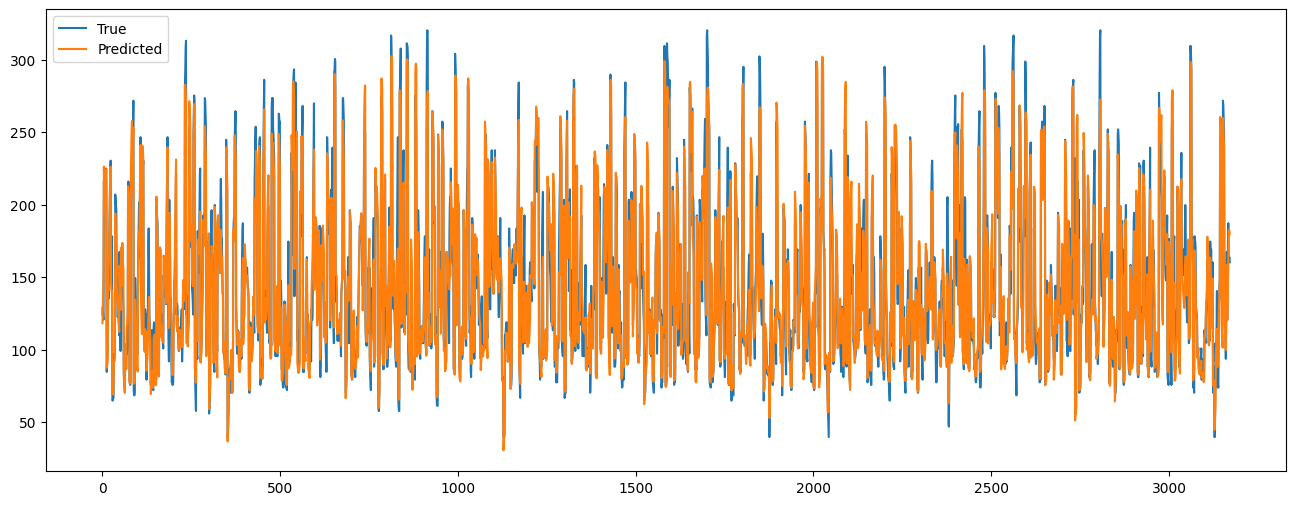

In [12]:
# LSTM预测
best_lstm_model.eval()
best_lstm_model.to(device)
print(f'model_name:{model_path}')
with torch.no_grad():
    y_pred = best_lstm_model(X_test_t.to(device))
    test_loss = criterion(y_pred, y_test_t.to(device))
    print(f'Test loss: {test_loss.item():.4f}')
    y_pred_lstm = best_lstm_model(X_test_t.to(device)).detach().cpu().numpy().flatten()
    mae_lstm = mean_absolute_error(y_true, y_pred_lstm)
print(f'LSTM MAE: {mae_lstm:.4f}')
# 可视化预测结果
plt.figure(figsize=(16, 6))
plt.plot(y_test_np.flatten(), label='True')
plt.plot(y_pred.cpu().numpy().flatten(), label='Predicted')
plt.legend()
plt.show()

## 计算15分钟，30分钟，45分钟，60分钟血糖的MAE

In [47]:
best_lstm_model.eval()
best_lstm_model.to(device)
print(f'model_name:{model_path}')
test_15,test_30,test_45,test_60=[],[],[],[]
pred_15,pred_30,pred_45,pred_60=[],[],[],[]
with torch.no_grad():
    y_pred = best_lstm_model(X_test_t.to(device))
    test_loss = criterion(y_pred, y_test_t.to(device))
    
for i in range(len(y_pred)):
    test_15.append(y_test_np[i][0])
    test_30.append(y_test_np[i][1])
    test_45.append(y_test_np[i][2])
    test_60.append(y_test_np[i][3])
    
    pred_15.append(y_pred.cpu().numpy()[i][0])
    pred_30.append(y_pred.cpu().numpy()[i][1])
    pred_45.append(y_pred.cpu().numpy()[i][2])
    pred_60.append(y_pred.cpu().numpy()[i][3])

# 计算MSE
mse_15min = np.mean((np.array(test_15) - np.array(pred_15)) ** 2)
mse_30min = np.mean((np.array(test_30) - np.array(pred_30)) ** 2)
mse_45min = np.mean((np.array(test_45) - np.array(pred_45)) ** 2)
mse_60min = np.mean((np.array(test_60) - np.array(pred_60)) ** 2)

# 计算MAE
mae_15min = np.mean(np.abs(np.array(test_15) - np.array(pred_15)))
mae_30min = np.mean(np.abs(np.array(test_30) - np.array(pred_30)))
mae_45min = np.mean(np.abs(np.array(test_45) - np.array(pred_45)))
mae_60min = np.mean(np.abs(np.array(test_60) - np.array(pred_60)))


print('MSE for each time period:\n')

print(f'MSE for 15 minute: {mse_15min}')
print(f'MSE for 30 minute: {mse_30min}')
print(f'MSE for 45 minute: {mse_45min}')
print(f'MSE for 60 minute: {mse_60min}')
print(f'MSE for one hour: {(mse_15min + mse_30min + mse_45min + mse_60min) / 4}')

print('MAE for each time period:\n')

print(f'MAE for 15 minute: {mae_15min}')
print(f'MAE for 30 minute: {mae_30min}')
print(f'MAE for 45 minute: {mae_45min}')
print(f'MAE for 60 minute: {mae_60min}')
print(f'MAE for one hour: {(mae_15min + mae_30min + mae_45min + mae_60min) / 4}')

model_name:best_lstm_model.pth
MSE for each time period:

MSE for 15 minute: 89.7302993698049
MSE for 30 minute: 180.3712628625243
MSE for 45 minute: 283.7302274737272
MSE for 60 minute: 388.28344116190135
MSE for one hour: 235.52880771698946
MAE for each time period:

MAE for 15 minute: 6.78191670613812
MAE for 30 minute: 9.62389103142641
MAE for 45 minute: 12.17818432070719
MAE for 60 minute: 14.458671298514098
MAE for one hour: 10.760665839196454


## 计算后一个小时血糖值

torch.Size([16, 6])


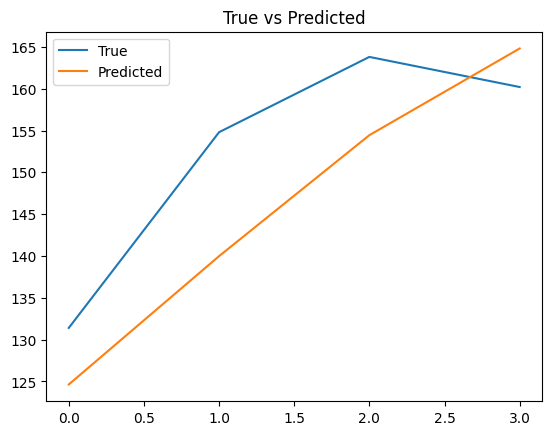

In [54]:
# 随机抽取一个测试集的样本进行预测
import random
random_index = random.randint(0, len(X_test_t) - 1)
x_sample = X_test_t[random_index]
print(x_sample.shape)

# 进行预测
best_lstm_model.eval()
with torch.no_grad():
    y_pred = best_lstm_model(x_sample.unsqueeze(0)).cpu().numpy().flatten()
    y_true = y_test_np[random_index]
    
# 可视化
plt.plot(y_true, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('True vs Predicted')
plt.show()